# Investigating the Multiprogramming Ability of EC2 Instances using a Cost-Benefit Analysis

<strong> Team 001 </strong>: Jason Platt, Jennifer Chien, Shuhao Chang, Yuanzhen Lin, Srishti Palani

# Question
How can parallelization help achieve best efficiency and multiprogramming ability for running tasks on EC2 instances?

Practical task: Given a certain task, how many processes should be spawned on a given instance to maximize the efficiency of computation. (Given a fixed matrix size, how many processes can achieve the highest efficiency/shortest time)

Theoretical limit: What is the maximum throughput (Flops/second) for a given instance? (Given a fixed machine what is the largest task we can do?)

# Introduction: 

- Cloud Computing enhances allows us to run computations on remote computer system resources, when we want to, without having to worry about actively managing resources. However, this ability comes at a price. Cloud providers typically use a "pay-as-you-go" model, which can lead to unexpected operating expenses if programmers or administrators are not familiar with cloud-pricing models. Since we want to maximize CPU time and utility for the cost of using an EC2 instance, in this project, we investigate the multiprogramming ability of different EC2 instances using a cost-benefit analysis.

- Multi-programming Ability: 
    - One of the most important roles of an Operating System is to assign compute power to the many processes that are need to be executed. 
    - In a non-multiprogrammed system, as soon as one job leaves the CPU and goes for some other task (say I/O ), the CPU becomes idle. The CPU keeps waiting and waiting until this job (which was executing earlier) comes back and resumes its execution with the CPU. So CPU remains free for all this while. 
    - Now it has a drawback that the CPU remains idle for a very long period of time. Also, other jobs which are waiting to be executed might not get a chance to execute because the CPU is still allocated to the earlier job.
    - This poses a very serious problem that even though other jobs are ready to execute, CPU is not allocated to them as the CPU is allocated to a job which is not even utilizing it (as it is busy in I/O tasks).
    - It cannot happen that one job is using the CPU for say 1 hour while the others have been waiting in the queue for 5 hours. To avoid situations like this and come up with efficient utilization of CPU, the concept of multi programming came up.
    - The main idea of multi programming is to maximize the CPU time.
    - Multiprogramming ability can be measured by the number of processes when CPU utility reaches the maximum point. When the number of processes does not exceed this point, the CPU is not fully used. After this point, cache and memory are not large enough to support all processes and they have to frequently require disk I/O, which leads to the decrease of CPU utilization called "Thrashing". 
    - Due to various cache and memory configuration of different types of EC2 instances, they have different multiprogramming levels. We want to check the maximum multiprogramming ability of different AWS EC2 instances.

# Needs Work!!!!!!!!!!!
- Method: To investigate the multiprogramming ability of different EC2 instances at different costs we: 
    - (i) wrote a standard python test script that  consumes memory and CPU time. We chose to multiply two NXN matrix
    - (ii) wrote a driver script which keeps forking new processes with the standard test program and measure the CPU utility at the same time. 
    - (iii) compared the spot prices of EC2 instances and their multiprogramming levels
    - (iv) used python libraries to parallel matrix multiplication, to see how speedup is related to increased threads.
    - (v) run the scripts on 12 different EC2 instances chosen based on their memory capacity, number of cores, and cost. 
    - (vi) analyze the differences to conclude which one is attractive at a reasonable price. 

#  Import Data

In [43]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

sns.set(style="darkgrid", context="talk", font_scale=0.8)
sns.set_palette('colorblind')
print(pd.__version__)

all_data_df=pd.read_csv(os.getcwd()+'/Data/All_Data.csv')
all_data_df.head()

1.0.3


,c5large_size_arr,c5large_num_proc,c5large_time_avg,c5large_time_std,c5large_cpu_ut_avg,c5large_cpu_ut_std,c5xlarge_size_arr,c5xlarge_num_proc,c5xlarge_time_avg,c5xlarge_time_std,...,m52xlarge_time_avg,m52xlarge_time_std,m52xlarge_cpu_ut_avg,m52xlarge_cpu_ut_std,m54xlarge_size_arr,m54xlarge_num_proc,m54xlarge_time_avg,m54xlarge_time_std,m54xlarge_cpu_ut_avg,m54xlarge_cpu_ut_std
0,1.0,1.0,0.001975,0.000489,7.500,23.848480,1.0,1.0,0.002566,0.000620,...,0.002366,0.000362,6.2500,24.20614591,1,1,0.002384,0.000356,0.93750,8.788975694
1,1.0,2.0,0.002731,0.000074,25.000,43.301270,1.0,2.0,0.002808,0.000173,...,0.002817,0.000082,11.2500,31.59806165,1,2,0.002892,0.000042,4.06250,19.34221016
2,1.0,4.0,0.005025,0.000040,47.500,48.669806,1.0,4.0,0.004706,0.000191,...,0.004601,0.000164,15.6250,34.08972536,1,4,0.004354,0.000049,4.06250,19.34221016
3,1.0,8.0,0.010276,0.001023,83.335,35.745241,1.0,8.0,0.008722,0.000605,...,0.008332,0.000526,33.7500,44.56385867,1,8,0.007967,0.000433,12.18750,30.48917585
4,1.0,16.0,0.020079,0.000243,98.335,7.257567,1.0,16.0,0.016030,0.000468,...,0.015340,0.000236,38.4375,37.58115676,1,16,0.014663,0.000111,14.26875,27.50151629


In [39]:
data = pd.read_pickle("pf.pkl")
new_data = []
for i in range(len(data)):
    temp = list(data.iloc[i][['N', '#procs', 'p_t_mean', 'p_t_std', 'p_c_mean', 'p_c_std', 'instance']])
    temp.append(True)
    new_data.append(temp)
    temp = list(data.iloc[i][['N', '#procs', 'np_t_mean', 'np_t_std', 'np_c_mean', 'np_c_std', 'instance']])
    temp.append(False)
    new_data.append(temp)
new_data = pd.DataFrame(new_data, columns=['N', '#procs', 'time_mean', 'time_std', 'cpu_mean', 'cpu_std', 'instance', 'parallel'])

new_data.to_csv("parallel_results.csv")
m5large = new_data['instance'] == 'm5large'
m5xlarge = new_data['instance'] == 'm5xlarge'
m52xlarge = new_data['instance'] == 'm52xlarge'
r5large = new_data['instance'] == 'r5large'
r5xlarge = new_data['instance'] == 'r5xlarge'
r52xlarge = new_data['instance'] == 'r52xlarge'
c5large = new_data['instance'] == 'c5large'
c5xlarge = new_data['instance'] == 'c5xlarge'
c52xlarge = new_data['instance'] == 'c52xlarge'

# Practical task: 
Given a certain task, how many processes should be spawned on a given instance to maximize the efficiency of computation. (Given a fixed matrix size, how many processes can achieve the highest efficiency/shortest time)

## Experiment
Split the matrix multiplication task in num_proc number of problems.  Give each problem to a child process to complete and then measure the time it takes to execute.

### Comparison across instance types

To answer this question we compare the different kinds of instances to one another in terms of both the time it takes to finish each process (i.e., the time for that worker process to spawn, complete the task and terminate) as well as the total cpu utility.  Also whether the computation is parallelized (True) or not (False).

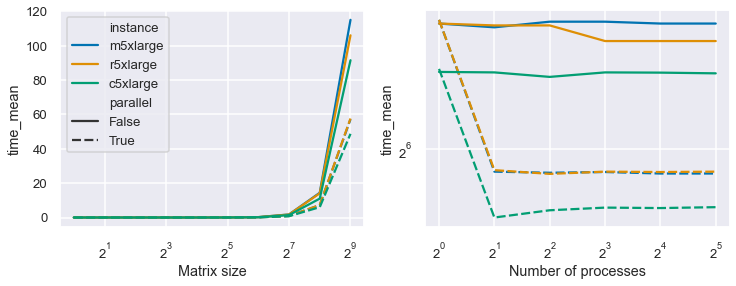

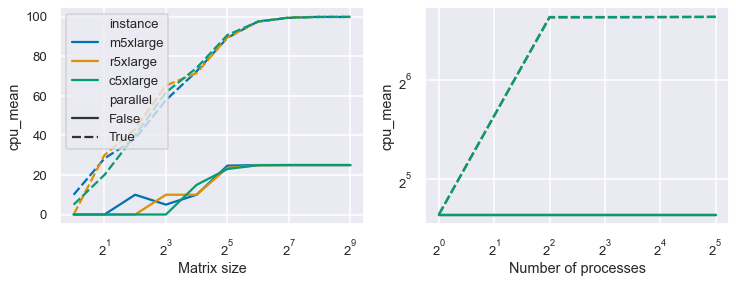

In [51]:
warnings.filterwarnings('ignore')
def mylineplot(data, criterion):
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(12, 4))

    sns.lineplot(x='N', y=criterion, hue='instance', style='parallel',data=data[data['#procs']==16], ax=ax1)
    ax1.set_xlabel('Matrix size')
    #ax1.set_ylabel('Wall time (s)')
    ax1.set_xscale('log', basex=2)
    ax2.set_yscale('log', basey=2)

    sns.lineplot(x='#procs', y=criterion, hue='instance', style='parallel', data=data[data['N']==512], ax=ax2, legend=None)
    ax2.set_xlabel('Number of processes')
    #ax2.set_ylabel('Wall time (s)')
    ax2.set_xscale('log', basex=2)
    ax2.set_yscale('log', basey=2)
    
# xlarge series
mylineplot(new_data[m5xlarge+r5xlarge+c5xlarge], 'time_mean')
mylineplot(new_data[m5xlarge+r5xlarge+c5xlarge], 'cpu_mean')

The conclusion from the above plot is that, as expected, the parallelized code outperforms the non-parallel code.  One can see this both from the cpu utilization graph, where the parallel code was more efficient in using the computational resources of the computer, and from the time per process.

Another conclusion is that the speedup from multiprocessing quickly caps out once a certain number of processes have been spawned.  The top right plot shows that once we have a certain number of children (equal to the number of cores in the computer), the time per process stays constant.  Since the problem is being split into more and more pieces this gives a maximum number of processes beyond which there is no more benefit.  We do not seem to have reach a thrashing limit, or rather the effect of thrashing is dwarfed by the speed up gained by multiprocessing.

### Comparison among the same instance type

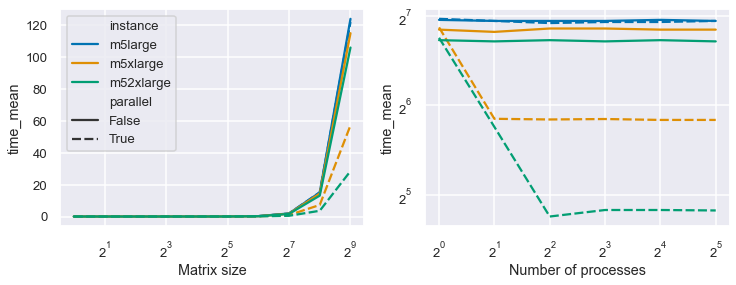

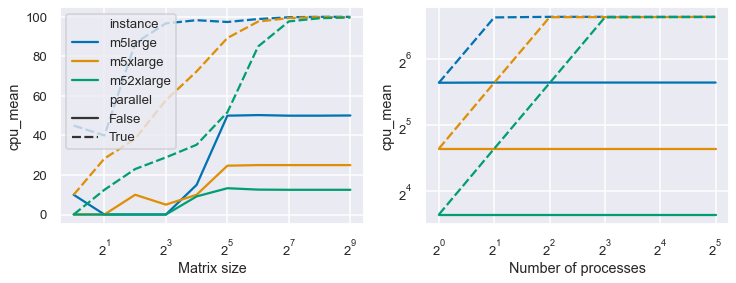

In [52]:
# m series
mylineplot(new_data[m5large+m5xlarge+m52xlarge], 'time_mean')
mylineplot(new_data[m5large+m5xlarge+m52xlarge], 'cpu_mean')

Now comparing across the same instance it is clear that "you get what you pay for" in terms of computing power.  The top right hand plot shows that the time per process levels out at a much higher level for multiprocessing on the large cluster than on the xlarge or 2xlarge.  We do see, however, a different point at which we maximize the cpu utility for different instances.  Depending on how bug a task is it might make more sense to use the smaller machines.  For instance, one needs 8 processes to maximize the cpu utility on the 2xlarge instance.

# Theoretical

Theoretical limit: What is the maximum throughput (Flops/second) for a given instance? (Given a fixed machine what is the largest task we can do?)

In [13]:
'''
Load and process data into dataframe format
'''
c52xlarge=pd.read_csv(os.getcwd()+'/Data/c52xlarge.csv')
c5xlarge=pd.read_csv(os.getcwd()+'/Data/c5xlarge.csv')
c5large=pd.read_csv(os.getcwd()+'/Data/c5large.csv')
m54xlarge=pd.read_csv(os.getcwd()+'/Data/m54xlarge.csv')
m52xlarge=pd.read_csv(os.getcwd()+'/Data/m52xlarge.csv')
m5xlarge=pd.read_csv(os.getcwd()+'/Data/m5xlarge.csv')
m5large=pd.read_csv(os.getcwd()+'/Data/m5large.csv')
r54xlarge=pd.read_csv(os.getcwd()+'/Data/r54xlarge.csv')
r52xlarge=pd.read_csv(os.getcwd()+'/Data/r52xlarge.csv')
r5xlarge=pd.read_csv(os.getcwd()+'/Data/r5xlarge.csv')
r5large=pd.read_csv(os.getcwd()+'/Data/r5large.csv')
c5large_raw = np.load(os.getcwd()+'/Data/raw/raw_data_c5large.npz')
c5xlarge_raw = np.load(os.getcwd()+'/Data/raw/raw_data_c5xlarge.npz')
c52xlarge_raw = np.load(os.getcwd()+'/Data/raw/raw_data_c52xlarge.npz')
r5large_raw = np.load(os.getcwd()+'/Data/raw/raw_data_r5large.npz')
r5xlarge_raw = np.load(os.getcwd()+'/Data/raw/raw_data_r5xlarge.npz')
r52xlarge_raw = np.load(os.getcwd()+'/Data/raw/raw_data_r52xlarge.npz')
r54xlarge_raw = np.load(os.getcwd()+'/Data/raw/raw_data_r54xlarge.npz')

## Experiment:
In this experiment we keep forking new processes each of which has to complete the entire matrix multiplication task.  Thus we are attempting to calculate the maximum throughput of the computer as it relates to the number of processes

Text(0.5, 0, 'Log(Number of Processes)')

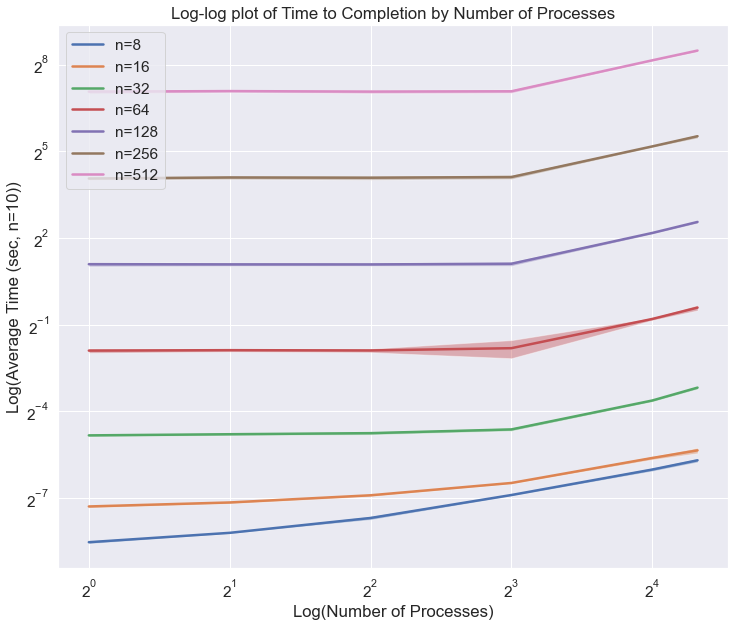

In [15]:
sns.set(font_scale=1.4)
ax = m54xlarge[m54xlarge.size_arr == 8].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=8")
m54xlarge[m54xlarge.size_arr == 16].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=16")
m54xlarge[m54xlarge.size_arr == 32].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=32")
m54xlarge[m54xlarge.size_arr == 64].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=64")
m54xlarge[m54xlarge.size_arr == 128].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=128")
m54xlarge[m54xlarge.size_arr == 256].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=256")
m54xlarge[m54xlarge.size_arr == 512].set_index('num_proc')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="n=512")

ax.fill_between(m54xlarge[m54xlarge.size_arr == 8]['num_proc'], 
                m54xlarge[m54xlarge.size_arr == 8]['time_avg']+2*m54xlarge[m54xlarge.size_arr == 8]['time_std'], 
                m54xlarge[m54xlarge.size_arr == 8]['time_avg']-2*m54xlarge[m54xlarge.size_arr == 8]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m54xlarge[m54xlarge.size_arr == 16]['num_proc'], 
                m54xlarge[m54xlarge.size_arr == 16]['time_avg']+2*m54xlarge[m54xlarge.size_arr == 16]['time_std'], 
                m54xlarge[m54xlarge.size_arr == 16]['time_avg']-2*m54xlarge[m54xlarge.size_arr == 16]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m54xlarge[m54xlarge.size_arr == 32]['num_proc'], 
                m54xlarge[m54xlarge.size_arr == 32]['time_avg']+2*m54xlarge[m54xlarge.size_arr == 32]['time_std'], 
                m54xlarge[m54xlarge.size_arr == 32]['time_avg']-2*m54xlarge[m54xlarge.size_arr == 32]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m54xlarge[m54xlarge.size_arr == 64]['num_proc'], 
                m54xlarge[m54xlarge.size_arr == 64]['time_avg']+2*m54xlarge[m54xlarge.size_arr == 64]['time_std'], 
                m54xlarge[m54xlarge.size_arr == 64]['time_avg']-2*m54xlarge[m54xlarge.size_arr == 64]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m54xlarge[m54xlarge.size_arr == 128]['num_proc'], 
                m54xlarge[m54xlarge.size_arr == 128]['time_avg']+2*m54xlarge[m54xlarge.size_arr == 128]['time_std'], 
                m54xlarge[m54xlarge.size_arr == 128]['time_avg']-2*m54xlarge[m54xlarge.size_arr == 128]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m54xlarge[m54xlarge.size_arr == 256]['num_proc'], 
                m54xlarge[m54xlarge.size_arr == 256]['time_avg']+2*m54xlarge[m54xlarge.size_arr == 256]['time_std'], 
                m54xlarge[m54xlarge.size_arr == 256]['time_avg']-2*m54xlarge[m54xlarge.size_arr == 256]['time_std'], 
                alpha = 0.4, interpolate=True)
ax.fill_between(m54xlarge[m54xlarge.size_arr == 512]['num_proc'], 
                m54xlarge[m54xlarge.size_arr == 512]['time_avg']+2*m54xlarge[m54xlarge.size_arr == 512]['time_std'], 
                m54xlarge[m54xlarge.size_arr == 512]['time_avg']-2*m54xlarge[m54xlarge.size_arr == 512]['time_std'], 
                alpha = 0.4, interpolate=True)

ax.legend()
plt.title("Log-log plot of Time to Completion by Number of Processes")
plt.xscale('log',basex=2)
plt.yscale('log',basey=2)
ax.set_ylabel("Log(Average Time (sec, n=10))")
ax.set_xlabel("Log(Number of Processes)")

What we see here is a comparison of the amount of time for each matrix multiplication task to finish, and the number of processes doing the processing at the same time.  The main feature here is the flat line up to $2^3$ processes, indicating that 8 matrix multiplications can be going on in parallel without affecting the speed of the others.  After 8 they start interfering with one another and the computation time increases.

For low matrix sizes N < 32 we see that the overhead for creating a new process is a significant contributor to the overall time.  This is indicated by the positive slope for those lines before the cutoff point of num proc = $2^3$

## Calculations per Second

We can normalize the graph by both the matrix size and the number of processes to give us the number of calculations output per second for each situation

Text(0.5, 0, 'Log(Number of Processes)')

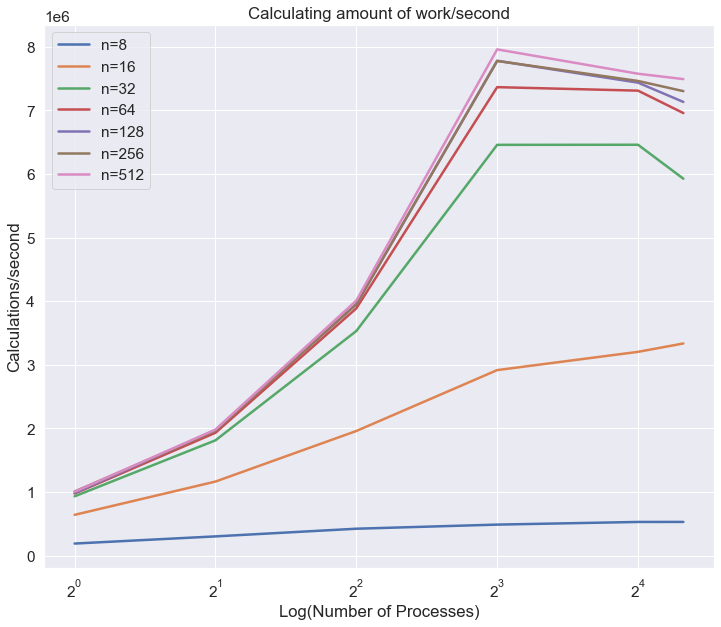

In [70]:
sns.set(font_scale=1.4)
num_proc = np.array([1, 2, 4, 8, 16, 20])
ax = (8**3/m54xlarge[m54xlarge.size_arr == 8].set_index('num_proc')['time_avg']*num_proc).plot(figsize=(12, 10), linewidth=2.5, label="n=8")
(16**3/m54xlarge[m54xlarge.size_arr == 16].set_index('num_proc')['time_avg']*num_proc).plot(figsize=(12, 10), linewidth=2.5, label="n=16")
ax = (32**3/m54xlarge[m54xlarge.size_arr == 32].set_index('num_proc')['time_avg']*num_proc).plot(figsize=(12, 10), linewidth=2.5, label="n=32")
(64**3/m54xlarge[m54xlarge.size_arr == 64].set_index('num_proc')['time_avg']*num_proc).plot(figsize=(12, 10), linewidth=2.5, label="n=64")
(128**3/m54xlarge[m54xlarge.size_arr == 128].set_index('num_proc')['time_avg']*num_proc).plot(figsize=(12, 10), linewidth=2.5, label="n=128")
(256**3/m54xlarge[m54xlarge.size_arr == 256].set_index('num_proc')['time_avg']*num_proc).plot(figsize=(12, 10), linewidth=2.5, label="n=256")
(512**3/m54xlarge[m54xlarge.size_arr == 512].set_index('num_proc')['time_avg']*num_proc).plot(figsize=(12, 10), linewidth=2.5, label="n=512")

ax.legend()
plt.title("Calculating amount of work/second")
plt.xscale('log',basex=2)
# plt.yscale('log',basey=2)
ax.set_ylabel("Calculations/second")
ax.set_xlabel("Log(Number of Processes)")

Clearly if one would like to maximize the work done by the computer it is better to have larger computations than smaller ones for each process.  There is, as always, a law of diminishing returns and the output of the computer peaks around 8,000,000 calculations per second before declining after the number of processes increases.

### Finnally we compare different instances and 

Text(0, 0.5, 'Time per Process (s)')

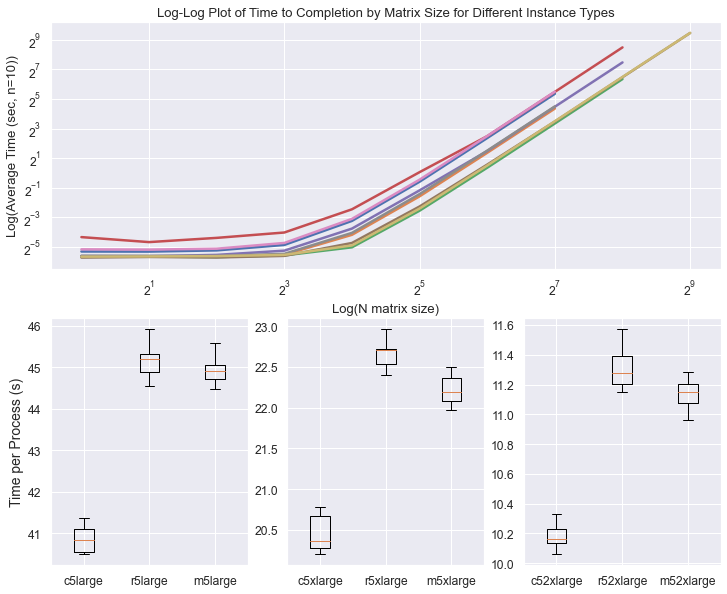

In [33]:
fig = plt.figure(figsize = (10, 8))
sns.set(font_scale=1.1)
ax1 = fig.add_subplot(2,1,1)
c5large[c5large.num_proc == 20].set_index('size_arr')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="c5large")
c5xlarge[c5xlarge.num_proc == 20].set_index('size_arr')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="c5xlarge")
c52xlarge[c52xlarge.num_proc == 20].set_index('size_arr')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="c52xlarge")
m5large[m5large.num_proc == 20].set_index('size_arr')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="m5large")
m5xlarge[m5xlarge.num_proc == 20].set_index('size_arr')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="m5xlarge")
m52xlarge[m52xlarge.num_proc == 20].set_index('size_arr')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="m52xlarge")
r5large[r5large.num_proc == 20].set_index('size_arr')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="r5large")
r5xlarge[r5xlarge.num_proc == 20].set_index('size_arr')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="r5xlarge")
r52xlarge[r52xlarge.num_proc == 20].set_index('size_arr')['time_avg'].plot(figsize=(12, 10), linewidth=2.5, label="r52xlarge")

# ax.legend()
ax1.set_ylabel("Log(Average Time (sec, n=10))")
ax1.set_xlabel("Log(N matrix size)")
plt.xscale('log',basex=2)
plt.yscale('log',basey=2)
plt.title("Log-Log Plot of Time to Completion by Matrix Size for Different Instance Types")

ind = 47
data_large = np.vstack((c5large_raw['times'][ind].T,
                        r5large_raw['times'][ind].T,
                        np.random.normal(loc=m5large['time_avg'].iloc[ind],
                        scale=m5large['time_std'].iloc[ind],
                        size = (10,1)).T))
labels_large = ['c5large', 'r5large', 'm5large']

data_xlarge = np.vstack((c5xlarge_raw['times'][ind].T,
                        r5xlarge_raw['times'][ind].T,
                        np.random.normal(loc=m5xlarge['time_avg'].iloc[ind],
                        scale=m5xlarge['time_std'].iloc[ind],
                        size = (10,1)).T))
labels_xlarge = ['c5xlarge', 'r5xlarge', 'm5xlarge']

data_2xlarge = np.vstack((c52xlarge_raw['times'][ind].T,
                          r52xlarge_raw['times'][ind].T,
                          np.random.normal(loc=m52xlarge['time_avg'].iloc[ind],
                          scale=m52xlarge['time_std'].iloc[ind],
                          size = (10,1)).T))
labels_2xlarge = ['c52xlarge', 'r52xlarge', 'm52xlarge']

ax2 = fig.add_subplot(2,3,4)
ax3 = fig.add_subplot(2,3,5)
ax4 = fig.add_subplot(2,3,6)

ax2.boxplot(data_large.T, labels = labels_large)
ax3.boxplot(data_xlarge.T, labels = labels_xlarge)
ax4.boxplot(data_2xlarge.T, labels = labels_2xlarge)
ax2.set_ylabel('Time per Process (s)', fontsize = 14)
# ax2.set_title('N = 128, num proc = 20', fontsize = 20)

Text(0.5, 1.0, 'Complexity of Matrix Multiplication num_proc = 20')

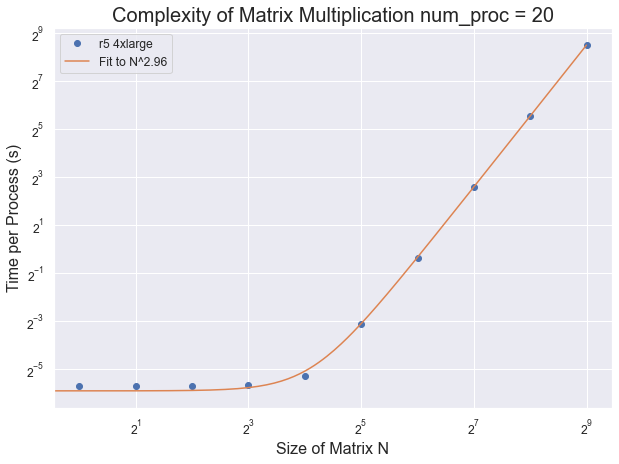

In [36]:
from scipy.optimize import curve_fit
x = np.power(2*np.ones(10), range(10))
data = r54xlarge_raw['times']
data = np.mean(data[5::6], axis = 1)

power_fit = lambda x, a, b, c: a*np.power(x, b)+c
popt, pcov = curve_fit(power_fit, x, data)

fig = plt.figure(figsize = (10,7))
plt.plot(x, data, 'o', label = 'r5 4xlarge')
plt.plot(np.arange(2**9), power_fit(np.arange(2**9), *popt),
        label = 'Fit to N^{:.2f}'.format(popt[1]))
plt.legend()
plt.xscale('log', basex = 2)
plt.yscale('log', basey = 2)
plt.xlabel('Size of Matrix N', fontsize = 16)
plt.ylabel('Time per Process (s)', fontsize = 16)
plt.title('Complexity of Matrix Multiplication num_proc = 20', fontsize = 20)